In [1]:
# necessary imports
import os
import time
import random

import torch
import torchinfo
import albumentations as A
import cv2 as cv
import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchmetrics import Accuracy
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

sns.set_theme(style="darkgrid", palette="muted")


In [2]:
def seed_basic(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
# torch random seed
def seed_torch(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
      
# basic + torch 
def seed_everything(seed=23):
    seed_basic(seed)
    seed_torch(seed)

In [3]:
DEFAULT_RANDOM_SEED = 2022
seed_everything(DEFAULT_RANDOM_SEED)

In [4]:
# define data path
base_path = os.path.dirname(os.getcwd())
base_path = os.path.join(base_path, "data/describable_textures_dtd")
meta_data = "unbalanced_data.csv"

In [5]:
# load the meta data
df = pd.read_csv(os.path.join(base_path, meta_data))
df.head(2)

,class_name,class_id,file_name
0,banded,0,banded_0133.jpg
1,banded,0,banded_0125.jpg


In [6]:
# train test split, stratify according to class ids
y = df.class_id
train_df, valid_df = train_test_split(df, test_size=300, stratify=y)

In [7]:
y.nunique()

47

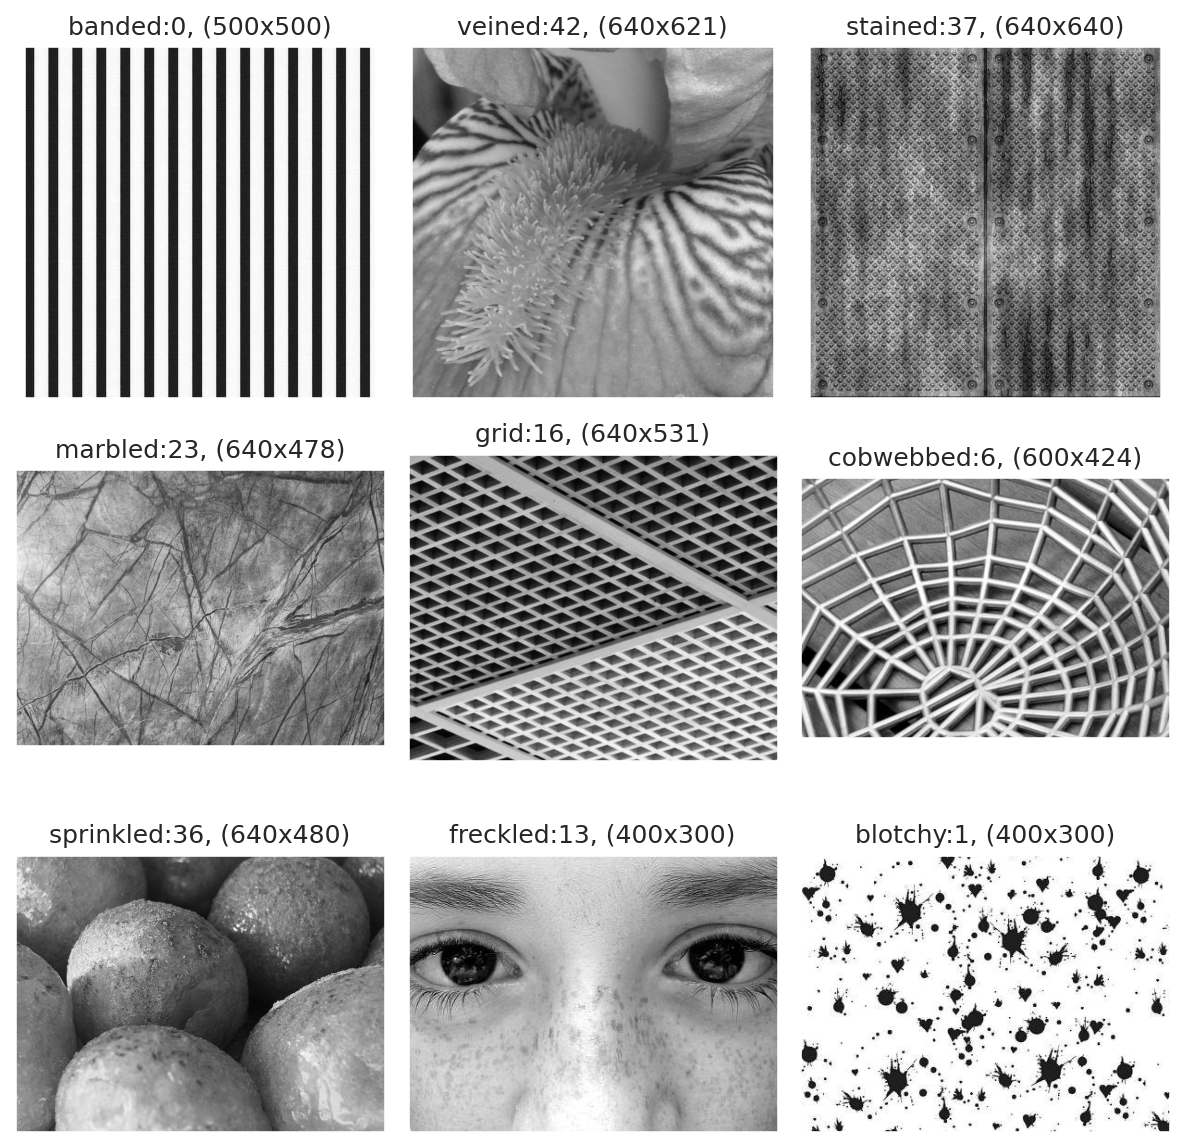

In [8]:
# inspect a few images
file_idx = np.random.choice(train_df.index.tolist(), size=9, replace=False)
images_dir = os.path.join(base_path, "images")
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(8, 8), dpi=150)
ax = ax.flatten()
for i, idx in enumerate(file_idx):
    class_name = train_df.loc[idx, "class_name"]
    class_id = train_df.loc[idx, "class_id"]
    file_name = train_df.loc[idx, "file_name"]
    image_path = os.path.join(images_dir, class_name, file_name)
    img = cv.imread(image_path)
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    ax[i].set_title(f"{class_name}:{class_id}, ({img.shape[1]}x{img.shape[0]})")
    ax[i].imshow(img, cmap="gray")
    ax[i].grid(False)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
fig.tight_layout()
plt.show()

In [9]:
# image augmentations
transforms = A.Compose([
    A.Resize(224, 224)
])

In [10]:
# create pytorch dataset
class PatternDataset(Dataset):
    def __init__(self, base_path:str, data:pd.DataFrame, tfms:A.Compose=None):
        self.base_path =base_path
        self.images_dir = os.path.join(self.base_path, "images")
        self.data = data
        self.tfms = tfms
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx:int):
        row = self.data.iloc[idx]
        target = row.class_id
        img_path = os.path.join(self.images_dir, row.class_name, row.file_name)
        img = cv.imread(img_path)
        # if img is not None:
        #     print(img_path, img.shape)
        # else:
        #     print(img_path)
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        img = img / 255. 
        if self.tfms is not None:
            img = self.tfms(image=img)["image"]
        
        img = img[np.newaxis, ...]
        img = torch.tensor(img, dtype=torch.float32)
        target = torch.tensor(target, dtype=torch.long)
        return img, target

In [11]:
# create datasets
train_dataset = PatternDataset(base_path, data=train_df, tfms=transforms)
valid_dataset = PatternDataset(base_path, data=valid_df, tfms=transforms)

# create dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, pin_memory=True)

dataloaders = {"train": train_loader, "valid": valid_loader}

In [12]:
len(train_dataset), len(valid_dataset)

(5340, 300)

In [13]:
# model
class CNNModel(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(3, 3))
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=(3, 3))
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=(3, 3))
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=(3, 3))
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)
        self.conv5 = nn.Conv2d(128, 128, kernel_size=(3, 3))
        self.maxpool5 = nn.MaxPool2d(kernel_size=2)

        self.fc1 = nn.LazyLinear(out_features=256)
        self.dropout = nn.Dropout(p=0.25)
        self.fc2 = nn.Linear(in_features=256, out_features=num_classes)

    def forward(self, x):
        x = self.maxpool1(self.conv1(x))
        x = F.relu(x)
        x = self.maxpool2(self.conv2(x))
        x = F.relu(x)
        x = self.maxpool3(self.conv3(x))
        x = F.relu(x)
        x = self.maxpool4(self.conv4(x))
        x = F.relu(x)
        x = self.maxpool5(self.conv5(x))
        x = F.relu(x)

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [14]:
# create model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel(num_classes=y.nunique())
x = torch.rand(4, 1, 224, 224)
out = model(x)
print(out.size())
torchinfo.summary(model, x.size(), device="cpu")

torch.Size([4, 47])


/home/lakshya/miniconda3/envs/pt/lib/python3.9/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Layer (type:depth-idx)                   Output Shape              Param #
CNNModel                                 [4, 47]                   --
├─Conv2d: 1-1                            [4, 16, 222, 222]         160
├─MaxPool2d: 1-2                         [4, 16, 111, 111]         --
├─Conv2d: 1-3                            [4, 32, 109, 109]         4,640
├─MaxPool2d: 1-4                         [4, 32, 54, 54]           --
├─Conv2d: 1-5                            [4, 64, 52, 52]           18,496
├─MaxPool2d: 1-6                         [4, 64, 26, 26]           --
├─Conv2d: 1-7                            [4, 128, 24, 24]          73,856
├─MaxPool2d: 1-8                         [4, 128, 12, 12]          --
├─Conv2d: 1-9                            [4, 128, 10, 10]          147,584
├─MaxPool2d: 1-10                        [4, 128, 5, 5]            --
├─Linear: 1-11                           [4, 256]                  819,456
├─Dropout: 1-12                          [4, 256]              

In [15]:
# define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

In [16]:
def train(
    n_epochs,
    dataloaders,
    model,
    accuracy,
    optimizer,
    criterion,
    device,
    scheduler=None,
):
    start = time.time()

    # monitor training and validation losses
    train_losses, train_accuracies = [], []
    valid_losses, valid_accuracies = [], []

    # iterate through all the epochs
    for epoch in range(1, n_epochs + 1):
        train_epoch_losses, train_epoch_accuracies = [], []
        valid_epoch_losses, valid_epoch_accuracies = [], []
        epoch_start = time.time()

        # put the model to training mode
        model.train()
        for (images, targets) in dataloaders["train"]:
            images = images.to(device)
            targets = targets.to(device)

            # clear any accumulated gradients
            optimizer.zero_grad()

            # feed forward
            predictions = model(images)

            # calculate the loss
            loss = criterion(predictions, targets)

            # backprop
            loss.backward()

            # optimizer step
            optimizer.step()

            # store batch loss and accuracy
            train_epoch_losses.append(loss.item())

            batch_accuracy = accuracy(predictions, targets)
            # train_epoch_accuracies.extend(batch_accuracy.cpu().numpy())
            train_epoch_accuracies.append(batch_accuracy.item())
            # print(f"train epoch accuracies: {train_epoch_accuracies}")
        train_epoch_loss = np.mean(train_epoch_losses)
        train_epoch_accuracy = np.mean(train_epoch_accuracies) * 100

        # evaluate
        model.eval()
        for (images, targets) in dataloaders["valid"]:
            images = images.to(device)
            targets = targets.to(device)

            # compute predictions with no backprop
            with torch.no_grad():
                predictions = model(images)

                # calculate the loss
                loss = criterion(predictions, targets)

            # store batch loss and accuracy
            valid_epoch_losses.append(loss.item())

            # batch_accuracy = accuracy(predictions, targets)
            # valid_epoch_accuracies.extend(batch_accuracy.cpu().numpy())
            batch_accuracy = accuracy(predictions, targets)
            # train_epoch_accuracies.extend(batch_accuracy.cpu().numpy())
            valid_epoch_accuracies.append(batch_accuracy.item())
            # print(f"train epoch accuracies: {train_epoch_accuracies}")

        valid_epoch_loss = np.mean(valid_epoch_losses)
        valid_epoch_accuracy = np.mean(valid_epoch_accuracies) * 100

        train_losses.append(train_epoch_loss)
        train_accuracies.append(train_epoch_accuracy)

        valid_losses.append(valid_epoch_loss)
        valid_accuracies.append(valid_epoch_accuracy)

        if scheduler is not None:
            scheduler.step(valid_epoch_loss)

        print(
            f"Epoch {epoch:02d} / {n_epochs:02d} \tTime taken:{(time.time() - epoch_start):.2f} seconds"
        )
        print(
            f"Training loss: {train_epoch_loss:5f} \tValidation loss: {valid_epoch_loss:5f}"
        )
        print(
            f"Training accuracy: {train_epoch_accuracy:.3f} \tValidation accuracy: {valid_epoch_accuracy:.3f}"
        )
    print(f"Training finished in {(time.time()-start):.2f} seconds.")

    return train_losses, valid_losses, train_accuracies, valid_accuracies


def plot_metrics(
    train_losses, train_accuracies, valid_losses, valid_accuracies
):
    fig, ax = plt.subplots(2, 1, sharex=True, figsize=(6, 8), dpi=150)
    fig.suptitle("Baseline (balanced classes)")

    x = range(1, len(train_losses) + 1)
    ax[0].plot(x, train_losses, label="Train")
    ax[0].plot(x, valid_losses, label="Valid")
    ax[0].legend(frameon=False, fontsize=8)
    # ax[0].xaxis.set_major_locator(ticker.MultipleLocator(1))
    # ax[0].tick_params(axis="both", which="both", labelsize=8)
    ax[0].set_title("Loss", fontsize=10)

    ax[1].plot(x, train_accuracies, label="Train")
    ax[1].plot(x, valid_accuracies, label="Valid")
    ax[1].legend(frameon=False, fontsize=8)
    # ax[1].xaxis.set_major_locator(plt.MultipleLocator(2))
    # ax[1].tick_params(axis="x", which="both", labelsize=7)
    ax[1].set_xlabel("Epoch", fontsize=9)
    ax[1].set_title("Accuracy", fontsize=10)

    fig.tight_layout()
    plt.show()


# def weight_init(m: nn.Module):
#     if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
#         nn.init.kaiming_uniform_(m.weight)
#         nn.init.zeros_(m.bias)


def main(n_epochs, model, criterion, optimizer, dataloaders, device):
    # get dataloaders
    # dataloaders = get_dataloaders(batch_size=batch_size)
    print(f"Number of training batches: {len(dataloaders['train'])}")
    print(f"Number of validation batches: {len(dataloaders['valid'])}")
    images, labels = next(iter(dataloaders["train"]))
    print(f"Images shape: {images[0].shape}")
    print(f"Labels shape: {labels[0]}")
    print(f"Using device: {device}")

    # put model to device
    model = model.to(device)

    # define accuracy
    accuracy = Accuracy(threshold=0.6).to(device)

    # learning rate scheduler
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    #     optimizer, "min", verbose=True, factor=0.6, patience=4
    # )

    # train and evaluate
    train_losses, valid_losses, train_accuracies, valid_accuracies = train(
        n_epochs,
        dataloaders,
        model,
        accuracy,
        optimizer,
        criterion,
        device,
        # scheduler,
    )

    # plot the results
    plot_metrics(
        train_losses, train_accuracies, valid_losses, valid_accuracies
    )

In [17]:
main(50, model, criterion, optimizer, dataloaders, device)

Number of training batches: 84
Number of validation batches: 10
Images shape: torch.Size([1, 224, 224])
Labels shape: 46
Using device: cuda
Epoch 01 / 50 	Time taken:17.19 seconds
Training loss: 3.840134 	Validation loss: 3.795871
Training accuracy: 1.711 	Validation accuracy: 2.812
Epoch 02 / 50 	Time taken:15.12 seconds
Training loss: 3.751760 	Validation loss: 3.719518
Training accuracy: 4.238 	Validation accuracy: 5.000


KeyboardInterrupt: 